In [12]:
import json
import fitz
import re
import nltk
import sklearn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import numpy as np
import pandas as pd

In [3]:
# Cargar PDF
doc = fitz.open("constitucio-politica-colombia-1991.pdf")
texto_total = ""

for pagina in doc:
    texto_total += pagina.get_text() + "\n"

# Dividir por artículos usando expresión regular
articulos = re.split(r'(Artículo\s+\d+\.?)', texto_total, flags=re.IGNORECASE)

# Combinar encabezado y cuerpo en cada artículo
estructura = []
for i in range(1, len(articulos), 2):
    titulo = articulos[i].strip()
    cuerpo = articulos[i+1].strip()
    estructura.append({
        "titulo": titulo,
        "contenido": cuerpo
    })

# Guardar en JSON
with open("articulos.json", "w", encoding="utf-8") as f:
    json.dump(estructura, f, ensure_ascii=False, indent=4)


In [4]:
# Cargar datos
with open('articulos.json', 'r', encoding='utf-8') as f:
    constitucion = json.load(f)

In [5]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\juan
[nltk_data]     esteban\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\juan
[nltk_data]     esteban\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Configurar stemmer en español
stemmer = SnowballStemmer('spanish')
stop_words = set(stopwords.words('spanish'))

In [7]:
# Función para limpiar texto
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    tokens = word_tokenize(texto, language='spanish')
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [8]:
# Limpiar artículos
articulos_limpios = {}

for articulo in constitucion:
    titulo = articulo["titulo"]
    texto = articulo["contenido"]
    articulos_limpios[titulo] = limpiar_texto(texto)


In [11]:
with open("articulos.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Conteo de artículos
conteo_articulos = sum(1 for item in data if item.get("titulo", "").lower().startswith("artículo"))
print(f"Número de artículos encontrados: {conteo_articulos}")



Número de artículos encontrados: 417


In [13]:
df = pd.DataFrame(data)
df['n_palabras'] = df['contenido'].apply(lambda x: len(x.split()))
df['n_caracteres'] = df['contenido'].apply(len)
df['n_oraciones'] = df['contenido'].apply(lambda x: len(re.findall(r'[.!?]', x)))

# Estadísticas descriptivas
print(df[['n_palabras', 'n_caracteres', 'n_oraciones']].describe())

        n_palabras  n_caracteres  n_oraciones
count   417.000000    417.000000   417.000000
mean     93.429257    614.980815     4.441247
std     126.123586    835.032930     6.872956
min       0.000000      0.000000     0.000000
25%      34.000000    221.000000     1.000000
50%      58.000000    384.000000     2.000000
75%     108.000000    735.000000     5.000000
max    1518.000000   9989.000000    71.000000


In [15]:
from collections import Counter
import re

# Unir todo el texto
corpus = ' '.join(df['contenido']).lower()
tokens = re.findall(r'\w+', corpus)

total_palabras = len(tokens)
palabras_unicas = set(tokens)
densidad_lexica = len(palabras_unicas) / total_palabras
frecuencia = Counter(tokens)

print(f"Total de palabras: {total_palabras}")
print(f"Palabras únicas: {len(palabras_unicas)}")
print(f"Densidad léxica: {densidad_lexica:.4f}")
print("Palabras más frecuentes:")
print(frecuencia.most_common(20))


Total de palabras: 38959
Palabras únicas: 4277
Densidad léxica: 0.1098
Palabras más frecuentes:
[('de', 3060), ('la', 2128), ('y', 1463), ('el', 1284), ('los', 1239), ('en', 948), ('las', 905), ('a', 746), ('que', 730), ('del', 608), ('por', 509), ('o', 439), ('ley', 399), ('para', 380), ('se', 374), ('con', 326), ('su', 276), ('no', 232), ('al', 218), ('estado', 188)]


In [16]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

# Descargar las stopwords si no lo has hecho
nltk.download('stopwords')
stopwords_es = set(stopwords.words('spanish'))

# Tokenizar y filtrar
tokens = re.findall(r'\w+', corpus.lower())
tokens_filtrados = [t for t in tokens if t not in stopwords_es and len(t) > 2]

# Análisis
frecuencia = Counter(tokens_filtrados)
print(f"Palabras únicas (sin stopwords): {len(set(tokens_filtrados))}")
print("Top 20 palabras sin stopwords:")
print(frecuencia.most_common(20))


Palabras únicas (sin stopwords): 4087
Top 20 palabras sin stopwords:
[('ley', 399), ('podrá', 179), ('república', 157), ('gobierno', 155), ('congreso', 134), ('nacional', 130), ('constitución', 126), ('presidente', 118), ('funciones', 116), ('ser', 114), ('general', 99), ('artículo', 94), ('entidades', 92), ('derecho', 89), ('podrán', 89), ('nación', 87), ('corte', 82), ('ejercicio', 79), ('derechos', 77), ('público', 77)]


[nltk_data] Downloading package stopwords to C:\Users\juan
[nltk_data]     esteban\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Descargar stopwords 
nltk.download('stopwords')
stopwords_es = stopwords.words('spanish')

# Crear vectorizador con las stopwords personalizadas
vectorizer = CountVectorizer(stop_words=stopwords_es, ngram_range=(2, 3), min_df=2)

# Ajustar al corpus (lista de contenidos)
corpus = df['contenido'].tolist()
X = vectorizer.fit_transform(corpus)

# Obtener n-gramas y sus frecuencias
frecuencias = X.toarray().sum(axis=0)
ngramas = vectorizer.get_feature_names_out()
resultados = sorted(zip(ngramas, frecuencias), key=lambda x: x[1], reverse=True)

# Mostrar top 20
print("Top 20 n-gramas más frecuentes (sin stopwords):")
for ngrama, freq in resultados[:20]:
    print(f"{ngrama}: {freq}")


Top 20 n-gramas más frecuentes (sin stopwords):
presidente república: 88
artículo transitorio: 63
general nación: 42
corte constitucional: 38
entidades territoriales: 36
corte suprema: 32
corte suprema justicia: 31
suprema justicia: 31
constitución ley: 30
podrá ser: 30
ley podrá: 29
determine ley: 26
establezca ley: 26
partidos movimientos: 25
gobierno nacional: 24
señale ley: 24
ley determinará: 23
servicios públicos: 23
podrán ser: 19
constitución leyes: 18


[nltk_data] Downloading package stopwords to C:\Users\juan
[nltk_data]     esteban\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


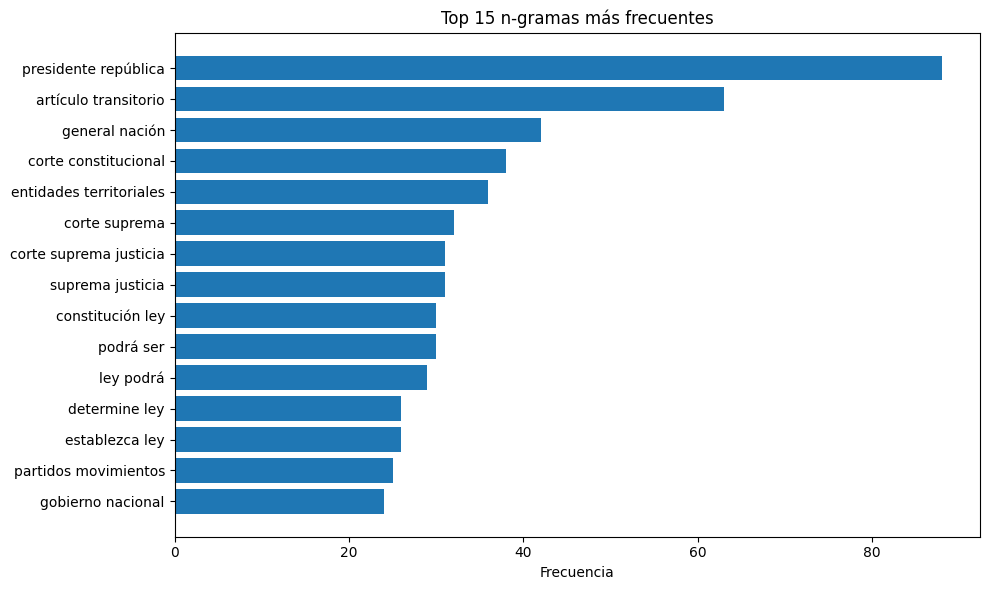

In [19]:
import matplotlib.pyplot as plt

top_ngrams = resultados[:15]
ng_textos, ng_freqs = zip(*top_ngrams)

plt.figure(figsize=(10, 6))
plt.barh(ng_textos[::-1], ng_freqs[::-1])
plt.title("Top 15 n-gramas más frecuentes")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

In [9]:
from sentence_transformers import SentenceTransformer

# Cargar modelo preentrenado para español
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Crear vectores de los artículos
vectores_articulos = {}
textos_originales = {}

for articulo in constitucion:
    num = articulo["titulo"]
    texto_original = articulo["contenido"]

    textos_originales[num] = texto_original
    embedding = modelo.encode(texto_original)
    vectores_articulos[num] = embedding

c:\Users\juan esteban\Documents\machine learning aplicado\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\juan esteban\Documents\machine learning aplicado\venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\juan esteban\.cache\huggingface\hub\models--sentence-transformers--distiluse-base-multilingual-cased-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you eith